In [1]:
import os
import numpy as np
import pandas as pd
import rasterio as rio
import matplotlib.pyplot as plt
import xarray as xr
import datetime as dt
import rioxarray
import seaborn as sns
import geopandas as gpd

In [20]:
# function to rewrite coordinates from metadata
def coord_range(ds):
    latrange = np.linspace(float(ds.attrs['Y_FIRST']),
                           ((float(ds.attrs['Y_STEP'])*float(ds.attrs['LENGTH']))+float(ds.attrs['Y_FIRST'])),
                           int(ds.attrs['LENGTH']))
    lonrange = np.linspace(float(ds.attrs['X_FIRST']),
                           ((float(ds.attrs['X_STEP'])*float(ds.attrs['WIDTH']))+float(ds.attrs['X_FIRST'])),
                           int(ds.attrs['WIDTH']))
    return latrange, lonrange

def mintpy2d_to_xarray(fn, crs):
    ds = xr.open_dataset(fn)
    ds = ds.rename_dims({'phony_dim_0':'y',
                         'phony_dim_1':'x'
                        })
    latrange, lonrange = coord_range(ds)
    ds = ds.assign_coords({'y': ('y', latrange),
                          'x': ('x', lonrange)})
    ds = ds.rio.write_crs(crs)
    
    return ds

In [29]:
mintpy_path = '/mnt/Backups/gbrench/repos/fusits/nbs/imja/agu_push/AT12/mintpy_fusion'
crs = 4326
vel_ds = mintpy2d_to_xarray(f'{mintpy_path}/geo/geo_velocity.h5', crs)
vel_ds = vel_ds.velocity.rio.write_nodata(0, inplace=True)
vel_ds = vel_ds * -1 # keep normal insar sign convention
vel_ds.rio.to_raster(f'{mintpy_path}/fusion_mean_velocity.tif')

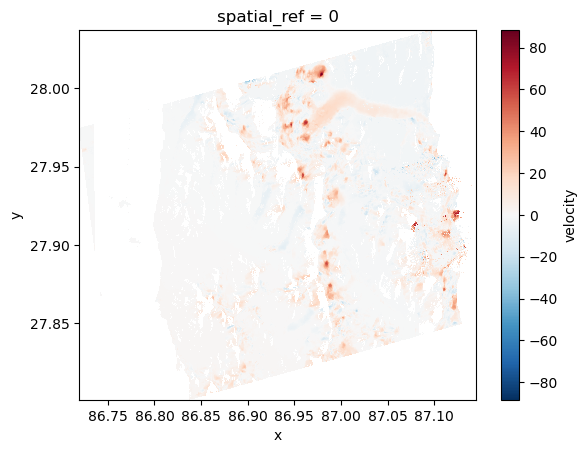

In [28]:
vel_ds.plot()

In [13]:
# export InSAR spatial coherence
mintpy_path = '/mnt/Backups/gbrench/repos/fusits/nbs/imja/agu_push/AT12/mintpy_igrams'
cor_ds = mintpy2d_to_xarray(f'{mintpy_path}/avgSpatialCoh.h5', crs)
#vel_ds.rio.to_raster(f'{mintpy_path}/offset_mean_velocity.tif')

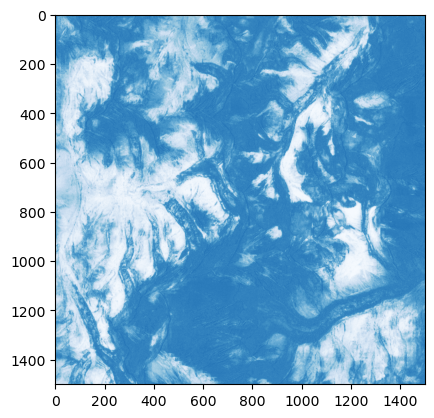

In [19]:
f, ax = plt.subplots()
ax.imshow(1- cor_ds.coherence, cmap='Blues', vmin=0, vmax=1)